# Cogs 118b Final Project 
## Comparing and Contrasting the Performance of Different Machine Learning Models on clustering and classifying animal sounds 

Group Members:
- Anand Mysorekar
- Alex Franz
- Jack Determan
- Austin Blanco

# Abstract

discuss what we tried and what we found high level

# Introduction

discuss clustering and classification as a task and the data we used 

# Methods

discuss the dataset (samples, instances, etc) and the models we used and the metrics we used to evaluate them

# Data Preprocessing, Feature Extraction, PCA, and Clustering



## Imports

In [7]:
import os
import warnings
import subprocess
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy.io import wavfile
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, 
    completeness_score, v_measure_score, classification_report, confusion_matrix
)
from minisom import MiniSom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, 
    Attention, Bidirectional
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, AdamW
from tensorflow.keras.applications import MobileNet



## Extracting Features using Librosa

Some commonly used audio features for classification include:

* **MFCCs (Mel-Frequency Cepstral Coefficients)**: Captures the timbral aspects of the sound, which is crucial for distinguishing sounds with similar pitches but different characteristics
* **Spectral Features**: Describes the shape of the spectrum and provide insights into the distribution of energy across frequencies
    * **Spectral Centroid**: Associated with brightness. Sounds with high spectral centroids (e.g., cymbals) are perceived as brighter, while sounds with low centroids (e.g., bass) are darker.
    * **Spectral Bandwidth**: A high bandwidth means the sound contains a wide range of frequencies (e.g., noise), while a narrow bandwidth suggests a pure tone
    * **Spectral Rolloff**: Indicates the "tail" of the spectrum. Useful for distinguishing tonal sounds (low rolloff) from noise-like sounds (high rolloff)
    * **Zero-Crossing Rate**: Higher rates are associated with noisier or percussive sounds, while lower rates occur in harmonic or tonal sounds
* **RMS Energy**: Loudness
*  **Chroma Features**: Rate of sign changes in the waveform 

In [9]:
def extract_features(file_path):

    y, sr = librosa.load(file_path, sr=None) 

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  
    mfccs_mean = np.mean(mfccs, axis=1)  

    # Spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

    # RMS energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Combine all features into a single vector
    features = np.hstack([
        mfccs_mean,
        spectral_centroid,
        spectral_bandwidth,
        spectral_rolloff,
        zero_crossing_rate,
        rms
    ])
    
    return features

def process_audio_directory(directory_path):

    data = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith('.wav'):  
            file_path = os.path.join(directory_path, file_name)
            
            try:
                features = extract_features(file_path)
                
                data.append([file_name] + list(features))
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
    other_columns = ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rms"]
    columns = ["file_name"] + mfcc_columns + other_columns

    df = pd.DataFrame(data, columns=columns)

    return df

def process_audio_directory_recursive(directory_path):
    
    data = []

    for root, _, files in os.walk(directory_path):
        for file_name in files:
            if file_name.endswith('.wav'): 
                file_path = os.path.join(root, file_name)
                
                try:
                    features = extract_features(file_path)
                    
                    data.append([file_name, file_path] + list(features))
                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
    
    mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
    other_columns = ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rms"]
    columns = ["file_name", "file_path"] + mfcc_columns + other_columns

    df = pd.DataFrame(data, columns=columns)
    return df

def plot_and_compute_metrics(df, model, expected_clusters, expected_labels):

    plt.figure(figsize=(10, 6))
    sns.heatmap(model, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
    plt.xlabel('Cluster')
    plt.ylabel('Animal Label')
    plt.title('Counts of Animal Labels per Cluster')
    plt.show()

    ari = adjusted_rand_score(df['animal_label'], df['cluster'])
    print(f"Adjusted Rand Index (ARI): {ari:.2f}")

    nmi = normalized_mutual_info_score(df['animal_label'], df['cluster'])
    print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

    homogeneity = homogeneity_score(df['animal_label'], df['cluster'])
    print(f"Homogeneity Score: {homogeneity:.2f}")

    completeness = completeness_score(df['animal_label'], df['cluster'])
    print(f"Completeness Score: {completeness:.2f}")

    v_measure = v_measure_score(df['animal_label'], df['cluster'])
    print(f"V-Measure Score: {v_measure:.2f}")

In [10]:
bear_file = "Animal_Sounds/Bear/Bear_1.wav"
bear_dir = "Animal_Sounds/Bear"
animal_dir = "Animal_Sounds"
animals = ["Animal_Sounds/Bear/Bear_1.wav","Animal_Sounds/Cat/Cat_1.wav","Animal_Sounds/Chicken/tavuk_1.wav","Animal_Sounds/Lion/Lion_1.wav"]

In [11]:
bear_sample = extract_features(bear_file)
print(bear_sample)

all_data = process_audio_directory_recursive(animal_dir)
all_data

[-4.26974449e+01  2.31592083e+01 -2.15544968e+01  2.83187675e+01
 -2.24801407e+01 -2.08504272e+00 -5.42245216e+01 -1.95991497e+01
 -1.69385281e+01 -1.93927460e+01 -2.62231503e+01 -2.08692589e+01
 -3.87858176e+00  1.45384062e+03  9.86992091e+02  2.64183728e+03
  2.45319235e-01  1.45496503e-01]


Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


,file_name,file_path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms
0,cat_74.wav,Animal_Sounds/Cat/cat_74.wav,-234.365860,62.569477,17.534571,22.115902,5.009671,17.376474,8.666010,16.502716,12.893415,10.851089,14.877017,7.365414,1.684717,1825.259537,2034.553737,4211.702642,0.106644,0.053829
1,cat_60.wav,Animal_Sounds/Cat/cat_60.wav,-362.939240,126.763588,21.480007,12.665357,20.749514,21.209866,22.983667,21.444958,14.674704,11.144953,5.874529,3.874768,1.905022,627.302400,1196.210765,1023.566480,0.031120,0.070479
2,cat_48.wav,Animal_Sounds/Cat/cat_48.wav,-328.694183,88.012619,-56.782753,-45.622047,16.819426,6.684614,-12.524681,15.798330,24.245670,-2.210051,-21.693911,-4.549113,-8.134430,1439.606344,1015.329501,2287.622798,0.146245,0.142621
3,cat_49.wav,Animal_Sounds/Cat/cat_49.wav,-222.318649,70.754372,-7.110373,6.576470,-2.695356,-0.933293,1.391536,-0.727772,-2.348461,-2.405308,-2.324493,-2.322320,-0.972328,1523.295963,1490.653194,3044.049202,0.120576,0.045249
4,cat_61.wav,Animal_Sounds/Cat/cat_61.wav,-300.509979,83.532295,-2.614404,9.347692,-3.951417,8.325131,0.832303,6.857069,-1.955612,3.896613,5.764127,4.906770,-2.291257,1830.064013,1840.472881,3850.020559,0.129896,0.040720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,Elephant_25.wav,Animal_Sounds/Elephant/Elephant_25.wav,-315.673523,20.894619,-37.539486,40.208420,-6.510990,-5.165436,5.387571,-5.869802,-7.356544,12.800898,3.845327,3.151396,2.855612,4273.021591,3057.532576,7494.654255,0.222519,0.083664
952,Elephant_19.wav,Animal_Sounds/Elephant/Elephant_19.wav,-154.741104,-27.926220,-22.073019,7.826798,-15.700511,3.784553,-1.754874,10.413884,-3.058660,6.787887,6.220902,12.452734,-5.266429,2524.323375,1360.660310,4125.195782,0.417937,0.074747
953,Elephant_18.wav,Animal_Sounds/Elephant/Elephant_18.wav,-358.656616,38.096474,-9.381742,28.722048,0.408628,4.316041,5.891005,3.334529,4.987509,5.735271,-4.123981,3.396932,-4.868723,3585.826001,2809.087701,6879.913330,0.224657,0.039202
954,Elephant_24.wav,Animal_Sounds/Elephant/Elephant_24.wav,-161.908066,-49.868374,7.743320,-2.468374,-18.794113,16.575644,-10.305703,3.386245,-12.408296,19.790922,-6.970393,20.319040,-0.997865,3020.181167,1228.271737,4279.413546,0.519516,0.125339


### Run PCA on the librosa-extracted features

Number of components selected: 13
Explained Variance Ratio: [0.26420085 0.11780065 0.10460981 0.07615927 0.07460547 0.06046135
 0.04978514 0.04527969 0.04093858 0.03537865 0.03394648 0.03083502
 0.02397616]
Total variance explained: 0.96
          0         1         2         3         4         5         6  \
0  1.263699  0.760016  2.921984  1.316383  0.411136  0.073798  0.567773   
1 -0.384406  0.320454  4.149472  1.866588 -0.263055  0.715463  0.117914   
2 -0.939269 -0.353078 -0.097107  2.399031 -0.740481 -1.766864  0.616733   
3 -0.427972 -0.154513  0.871013  0.025232 -0.474163 -0.395163 -0.483301   
4  0.602603 -0.057170  1.570686  0.241599 -0.129059 -0.273632  0.039532   

          7         8         9        10        11        12 animal_label  
0  0.631614  0.252274  0.021137  0.024958  0.494562  0.461254          cat  
1  0.356806 -0.588094 -1.035214  0.691917  0.172228 -0.373251          cat  
2 -0.580492 -1.455836 -0.658466  0.594746 -0.043192 -2.210360          cat  
3  

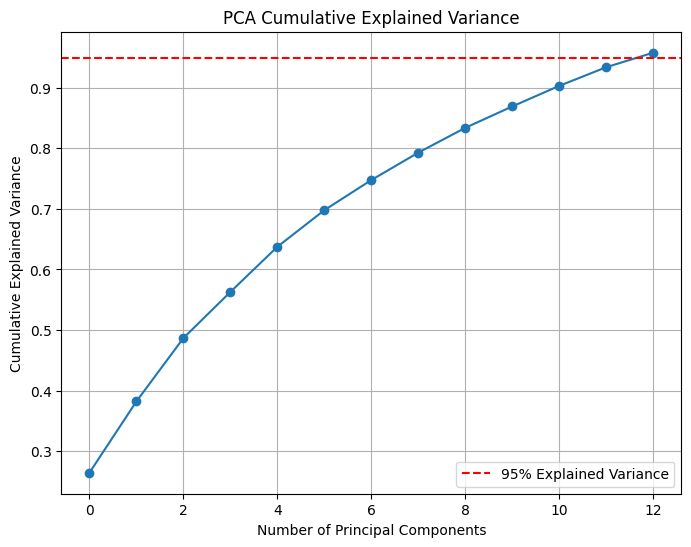

In [13]:
# Drop non-numeric columns
animal_features = all_data.drop(columns=["file_name","file_path"])  

# Standardize the data
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(animal_features)

# Apply PCA 
pca = PCA(n_components=0.95)  
principal_components_librosa = pca.fit_transform(animal_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components_librosa)

print(f"Number of components selected: {pca.n_components_}")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

pca_df['file_name'] = all_data['file_name'].values
pca_df['animal_label'] = pca_df['file_name'].str.split('_').str[0]
pca_df = pca_df.drop(columns=["file_name"]) 
print(pca_df.head())

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc='best')
plt.grid()
plt.show()

### Perform KMeans clustering on the principal components

cluster        0   1   2   3   4   5   6   7   8   9
animal_label                                        
Bear           8   0   0  35   0   0   0   0   5   2
Cow           13   2   1   3   1   0   0   4   9  17
Dolphin        0   5   0  10  35   0   0   0   0   0
Donkey         1   8   0   3  11   0   0   1  19   7
Elephant       1  10   2   2   7   0   4  12   9   3
Frog           0   3   4  11   5   0   5   3   6  13
Horse          0   1   0   3  18   0   1   0   7   1
Kus            0   0   0   0   0  40  60   0   0   0
Lion           5   0   0   7   0   0   1   0  26  11
aslan          7   0   0   3   0   0   0   0  24  11
cat            3   2   2  55   9   0   0   3  25   1
dog            0   0  68   9   0   0   0   2  21   0
esek           2   6   0   0   0   0   0   1  11   5
inek          19   4   2   6   1   0   0   8  15  20
koyun          0   6   1   3   8   1   1  18   2   0
kurbaga        0   3   3   7   4   0   1   2   5  10
maymun         1   3   0   6   6   1   1   2  

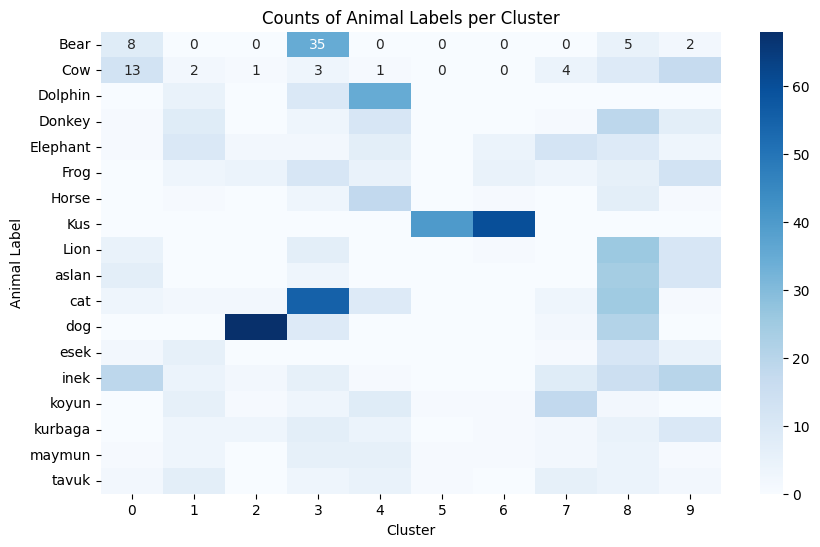

Adjusted Rand Index (ARI): 0.19
Normalized Mutual Information (NMI): 0.34
Homogeneity Score: 0.30
Completeness Score: 0.39
V-Measure Score: 0.34


In [15]:
# Run K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(principal_components_librosa)

# Create a contingency matrix
contingency_matrix_k_means = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(kmeans.n_clusters)
expected_labels = sorted(pca_df['animal_label'].unique())

# Reindex the contingency matrix to include all expected clusters and labels
contingency_matrix_k_means = contingency_matrix_k_means.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_k_means)

plot_and_compute_metrics(pca_df, contingency_matrix_k_means, expected_clusters, expected_labels)

### Perform Spectral Clustering on the principal components

cluster        0   1   2   3   4  5   6   7   8
animal_label                                   
Bear          37   0   2   0   0  4   0   0   0
Cow            6   1  28   1   0  8   0   0   0
Dolphin       10   0   3  37   0  0   0   0   0
Donkey         6   0  32  12   0  0   0   0   0
Elephant       4   1  23   7   0  0   0   3   0
Frog          15   0  12   3   0  0   0   0  10
Horse         10   0   3  16   0  0   0   0   0
Kus            0   0   0   0  40  0  14  46   0
Lion           8   0   8   0   0  0   0   0   0
aslan          3   0   9   0   0  0   0   0   0
cat           64   0  21   1   0  0   0   0   0
dog            9  59   5   0   0  0   0   0   0
esek           0   0  22   3   0  0   0   0   0
inek          11   1  44   3   0  8   0   0   0
koyun          5   0  23  11   0  0   0   0   0
kurbaga        7   0  10   3   0  0   0   0   7
maymun         7   0   7   6   1  0   0   0   0
tavuk          8   0  16   2   0  0   0   0   0


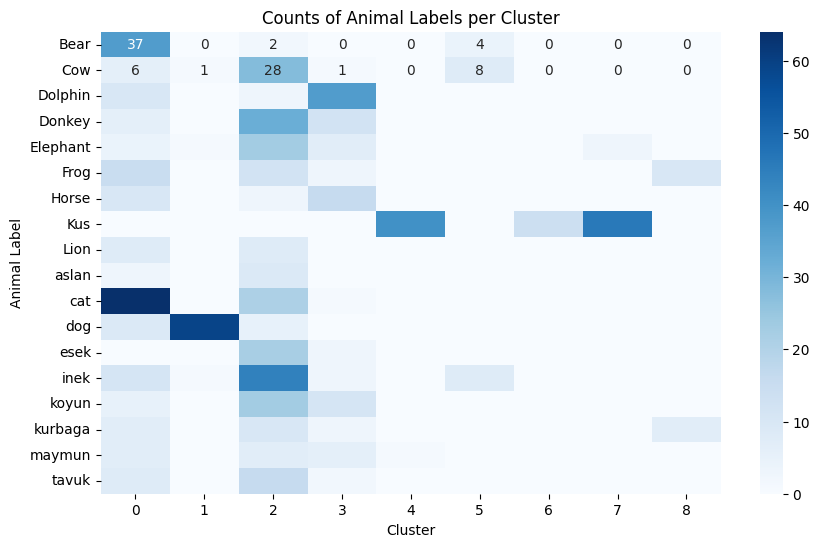

Adjusted Rand Index (ARI): 0.14
Normalized Mutual Information (NMI): 0.37
Homogeneity Score: 0.31
Completeness Score: 0.45
V-Measure Score: 0.37


In [17]:
# Run Spectral Clustering
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
pca_df['cluster'] = spectral.fit_predict(principal_components_librosa)

# Create a contingency matrix
contingency_matrix_spectral = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(9)  
expected_labels = sorted(pca_df['animal_label'].unique())

# Reindex the contingency matrix to include all expected clusters and labels
contingency_matrix_spectral = contingency_matrix_spectral.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_spectral)

plot_and_compute_metrics(pca_df, contingency_matrix_spectral, expected_clusters, expected_labels)

### Perform GMM clustering on the principal components

cluster        0   1   2   3   4   5   6   7   8
animal_label                                    
Bear          10   0   0  38   0   0   0   0   1
Cow           15   4   1   8   1   0   0   4   0
Dolphin        0   6   0   9  34   0   0   1   0
Donkey         1   7   0   9   9   0   0   1  16
Elephant       1  11   0  12   4   0   0  12   7
Frog           0   4   4   7   7   0   3   7   8
Horse          0   1   0   9  17   0   0   3   1
Kus            0   0   0   0   0  40  60   0   0
Lion          11   0   0   8   0   0   0   0  17
aslan         11   0   0   3   0   0   0   0  17
cat            5   5   2  73   4   0   0   5   6
dog            8   1  66  14   1   0   0   1   9
esek           1   6   0   2   0   0   0   2   9
inek          20   6   2  15   1   0   0   9   4
koyun          0  12   1   6   3   1   1  14   1
kurbaga        0   4   3   3   6   0   1   4   7
maymun         0   3   0   6   8   1   0   3   3
tavuk          3   6   0   8   2   1   0   9   1


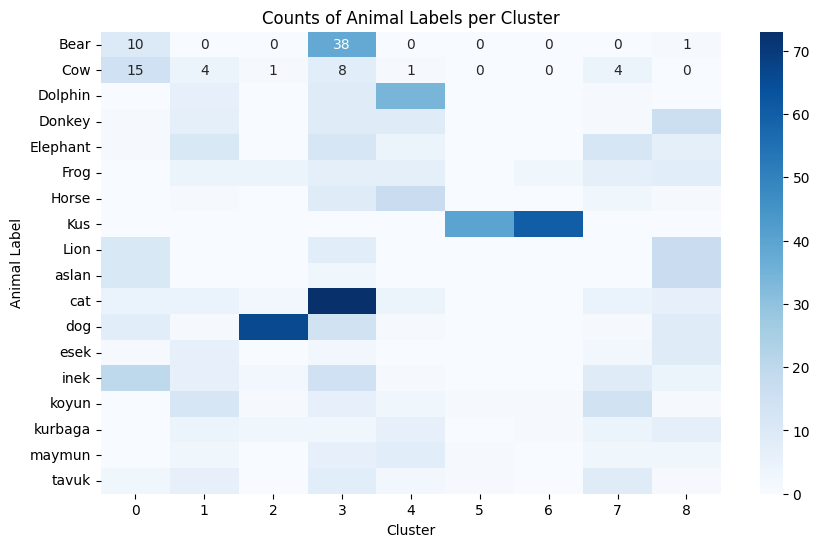

Adjusted Rand Index (ARI): 0.20
Normalized Mutual Information (NMI): 0.35
Homogeneity Score: 0.31
Completeness Score: 0.39
V-Measure Score: 0.35


In [19]:
# Run Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
pca_df['cluster'] = gmm.fit_predict(principal_components_librosa)

# Create a contingency matrix
contingency_matrix_gmm = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(9) 
expected_labels = sorted(pca_df['animal_label'].unique())

# Reindex the contingency matrix to include all expected clusters and labels
contingency_matrix_gmm = contingency_matrix_gmm.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_gmm)

plot_and_compute_metrics(pca_df, contingency_matrix_gmm, expected_clusters, expected_labels)

### Perform Self-Organizing Maps clustering on the principal components

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.9399061773216846


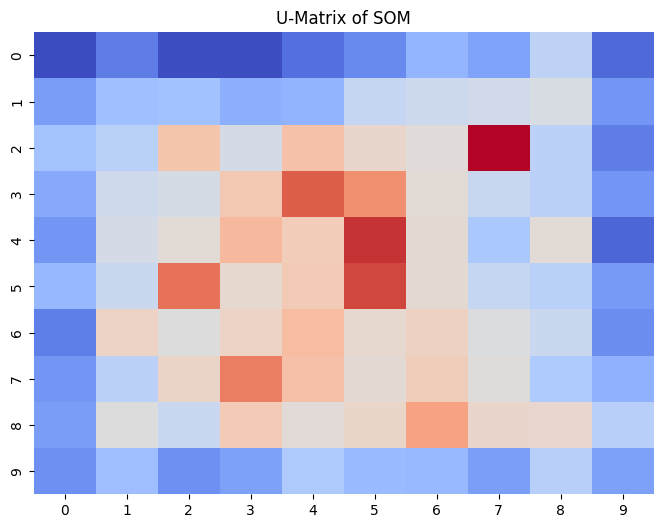

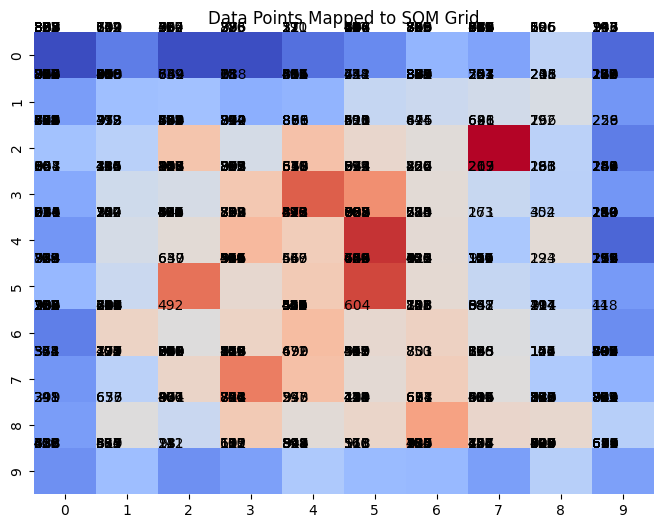

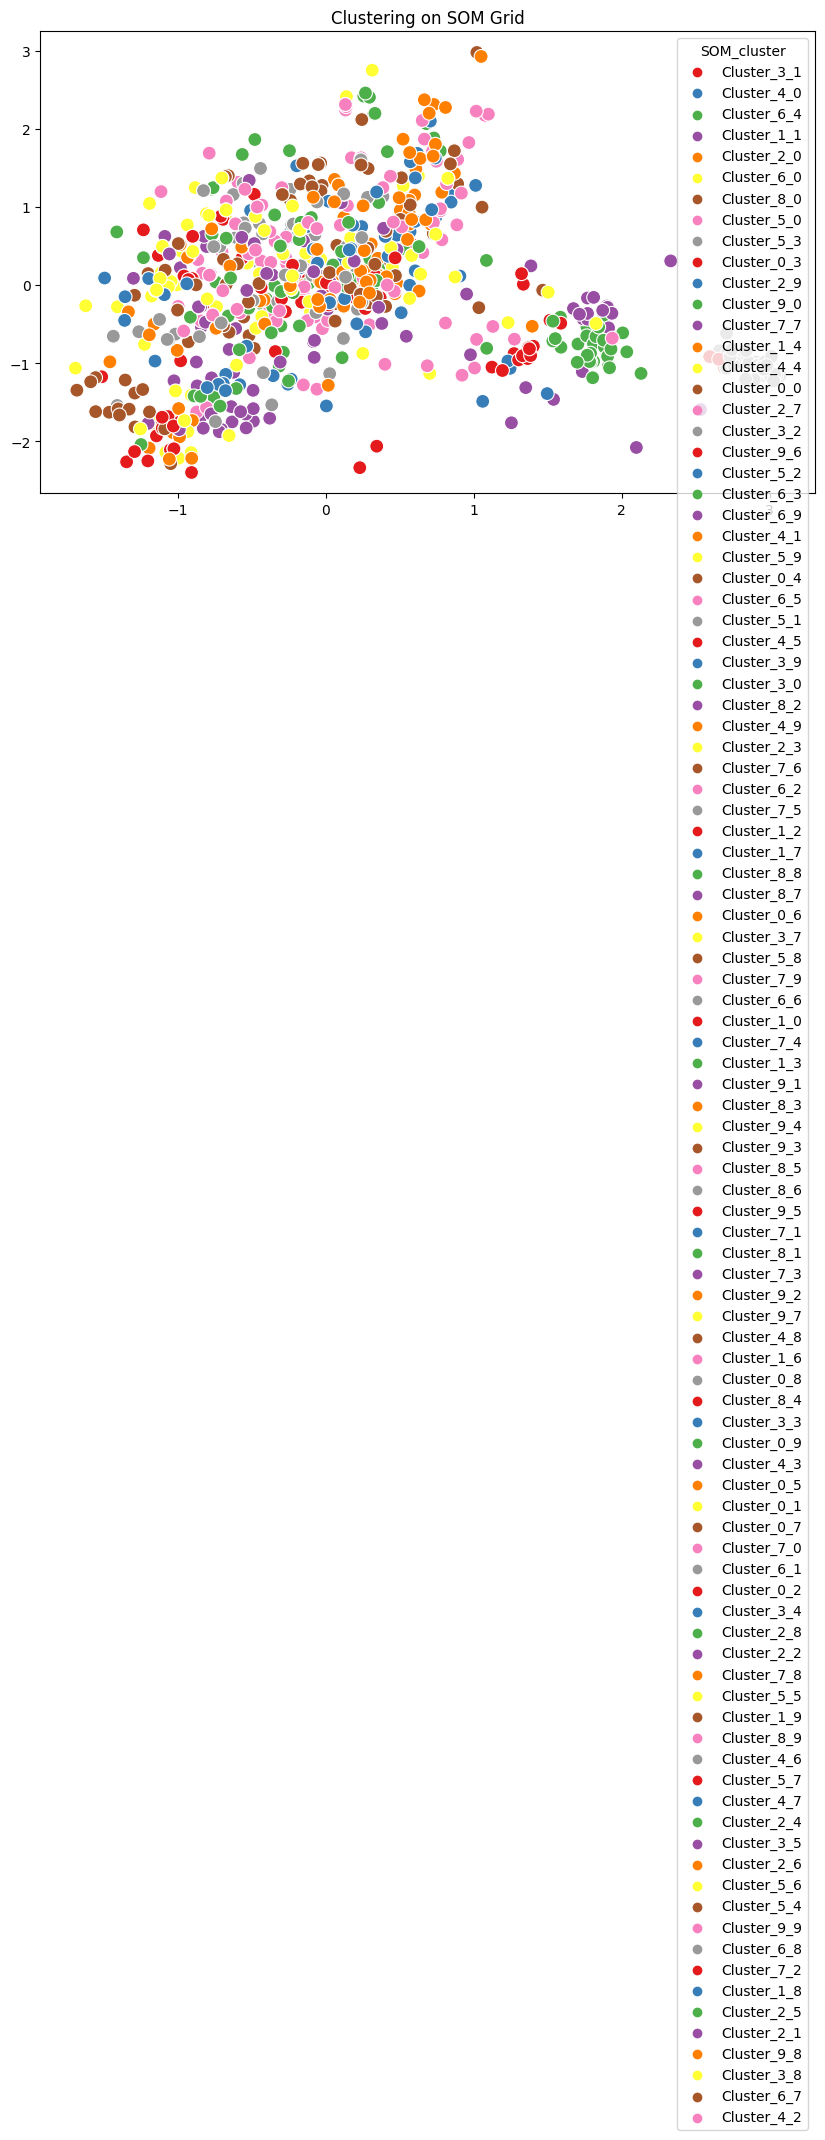

Adjusted Rand Index (ARI): 0.14
Normalized Mutual Information (NMI): 0.48
Homogeneity: 0.62
Completeness: 0.39
V-Measure: 0.48


In [21]:
# Standardize the data 
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(principal_components_librosa) 

# Initialize the SOM
som = MiniSom(x=10, y=10, input_len=animal_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)

# Train the SOM
som.train(animal_scaled, 1000, verbose=True)

# Plot the SOM's U-matrix
# U-matrix visualizes the distance between the neurons in the SOM grid. Larger distances mean dissimilarity.
plt.figure(figsize=(8, 6))
plt.title("U-Matrix of SOM")
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)
plt.show()

# Plot the data points on the SOM grid
plt.figure(figsize=(8, 6))
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)

# Assign each data point to a neuron (winning node)
win_map = som.win_map(animal_scaled)

# We can use the same colors to show where the data points map on the SOM grid
for label in range(len(animal_scaled)):
    x, y = som.winner(animal_scaled[label])
    plt.text(x, y, str(label), color='black', fontsize=10)

plt.title('Data Points Mapped to SOM Grid')
plt.show()

# Visualize the SOM clusters
# Cluster the data points by grouping based on their winning node
# You can assign each point a cluster label (i.e., the coordinates of the winning node)
labels_som = np.array([som.winner(x) for x in animal_scaled])

# Convert coordinates to cluster labels
cluster_labels = np.array([f'Cluster_{x[0]}_{x[1]}' for x in labels_som])

pca_df['SOM_cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=animal_scaled[:, 0], y=animal_scaled[:, 1], hue=pca_df['SOM_cluster'], palette='Set1', s=100)
plt.title("Clustering on SOM Grid")
plt.show()

# Clustering performance metrics
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Homogeneity: {homogeneity:.2f}")

completeness = completeness_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Completeness: {completeness:.2f}")

v_measure = v_measure_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"V-Measure: {v_measure:.2f}")

### Results of Librosa Feature Extraction Clustering Results


put evaluation metrics for each model here in a table just for easy viewing

## Processing the File using a Spectrogram 

talk about the spectrogram and how we used it to extract features

In [24]:
def plot_spectrograms_grid(audio_files, rows, cols, figsize=(15, 10), cmap='viridis'):
    
    if rows * cols < len(audio_files):
        raise ValueError("Grid size (rows * cols) is smaller than the number of audio files.")
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axes = axes.flatten() 

    for i, audio_file in enumerate(audio_files):
        y, sr = librosa.load(audio_file)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap=cmap, ax=axes[i])
        axes[i].set_title(f'Spectrogram: {audio_file}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Frequency (Hz)')

    for j in range(len(audio_files), len(axes)):
        axes[j].axis('off')

    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes, format='%+2.0f dB', orientation='vertical', fraction=0.02, pad=0.04)
    plt.show()

def process_wav_directory_to_spectrogram_df(root_dir):
   
    data = []
    file_paths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)  # Use original sample rate
                    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
                    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB scale
                    
                    flattened_spectrogram = S_dB.flatten()
                    data.append(flattened_spectrogram)
                    file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    df = pd.DataFrame(data)
    df['file_path'] = file_paths  

    return df

def extract_label(file_path):
    
    parts = os.path.normpath(file_path).split(os.sep)
    return parts[1]  


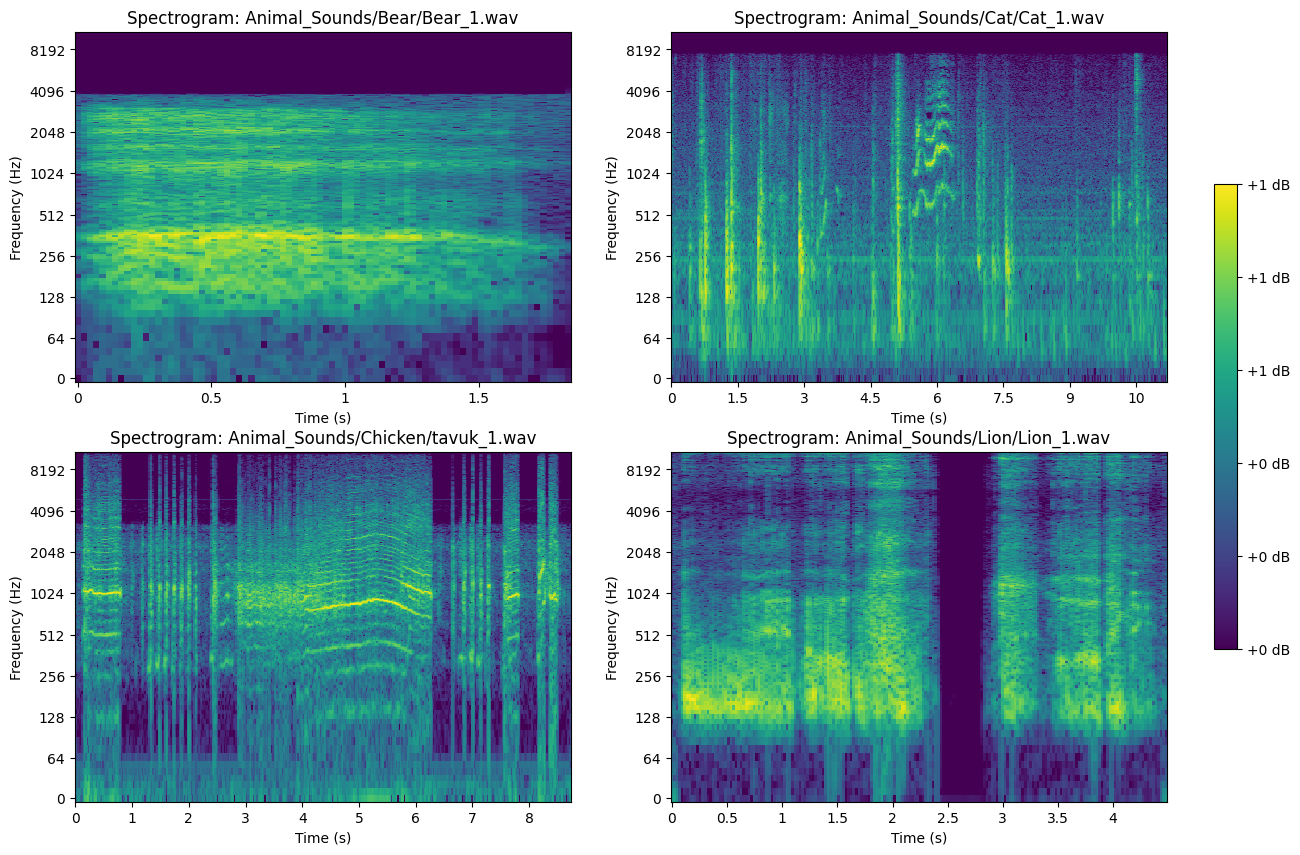

In [25]:
plot_spectrograms_grid(animals,rows=2,cols=2)

In [26]:
spectrogram_data = process_wav_directory_to_spectrogram_df(animal_dir)
spectrogram_data = spectrogram_data.fillna(0)
spectrogram_data

file_path = 'Animal Sounds/Cat/Cat_17.wav'
label = extract_label(file_path)
print(label)  

/opt/anaconda3/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Cat


### Run PCA on the Spectrogram-Extracted Features

Number of components selected: 105
Explained Variance Ratio: [4.69711201e-01 1.34353681e-01 6.26117495e-02 4.40874284e-02
 3.30310849e-02 2.31709860e-02 1.99450556e-02 1.43610016e-02
 1.23388517e-02 1.14467154e-02 9.16925118e-03 7.32171278e-03
 6.95324999e-03 5.56953567e-03 5.39254354e-03 4.81960549e-03
 4.32224962e-03 3.72572168e-03 3.55574346e-03 3.44450238e-03
 3.06465221e-03 2.96866076e-03 2.82471592e-03 2.34964541e-03
 2.20138516e-03 2.13904498e-03 2.00865671e-03 1.88338926e-03
 1.78801968e-03 1.69942510e-03 1.63549078e-03 1.55084268e-03
 1.41307383e-03 1.27597092e-03 1.24229317e-03 1.21196082e-03
 1.17393078e-03 1.14642609e-03 1.08009154e-03 1.03678589e-03
 9.77114124e-04 9.67492455e-04 9.24345905e-04 9.17589272e-04
 9.09438458e-04 8.97392554e-04 8.62505602e-04 8.53644373e-04
 7.67169478e-04 7.64623435e-04 7.38255432e-04 7.14244942e-04
 7.03387453e-04 6.87638316e-04 6.67172806e-04 6.58550603e-04
 6.42176212e-04 6.19318756e-04 6.10957183e-04 6.02715006e-04
 5.85511388e-04 5.633032

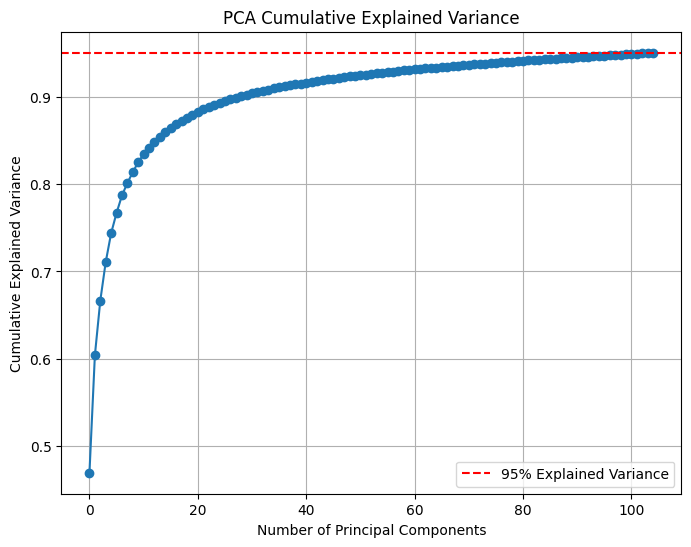

In [28]:
spectrogram_data_num = spectrogram_data.drop(columns="file_path") 

# Standardize the data
scaler = StandardScaler()
spectrogram_scaled = scaler.fit_transform(spectrogram_data_num)

# Apply PCA 
pca = PCA(n_components=0.95)  
principal_components_spectrogram = pca.fit_transform(spectrogram_data_num)

pca_df = pd.DataFrame(data=principal_components_spectrogram)

print(f"Number of components selected: {pca.n_components_}")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

pca_df['file_path'] = spectrogram_data['file_path'].values
pca_df['animal_label'] = pca_df['file_path'].apply(extract_label)
pca_df = pca_df.drop(columns=["file_path"]) 
print(pca_df.head())

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc='best')
plt.grid()
plt.show()

### Perform KMeans clustering on the principal components

cluster        0   1   2   3   4   5   6   7  8   9
animal_label                                       
Bear          34   1  16   9   5   2   3   2  0  23
Bird           1   3   0   7   0  45   4  33  7   0
Cat           12  50   3   3   2   4  12   2  3   9
Chicken       19   1   0   0   2   0   1   2  2   3
Cow           51   0  12   5  19   7   1   2  0  28
Dog            1   8  23  11   9  12   7  17  3   9
Dolphin       38   0   0   0   2   0   0   1  0   9
Donkey        26   2   4   3   2   0   3   6  0  29
Elephant       8   0   4   8  10   4   2   8  0   6
Frog          41   3   3   7  11   0   4   8  1   7
Horse         11   0   2   0   6   2   0   0  0  10
Lion          11   2  10   8   4   2   4   3  3   3
Monkey         2   3   1   4   1   1   1   5  1   6
Sheep         20   1   3   1   4   1   0   3  1   6


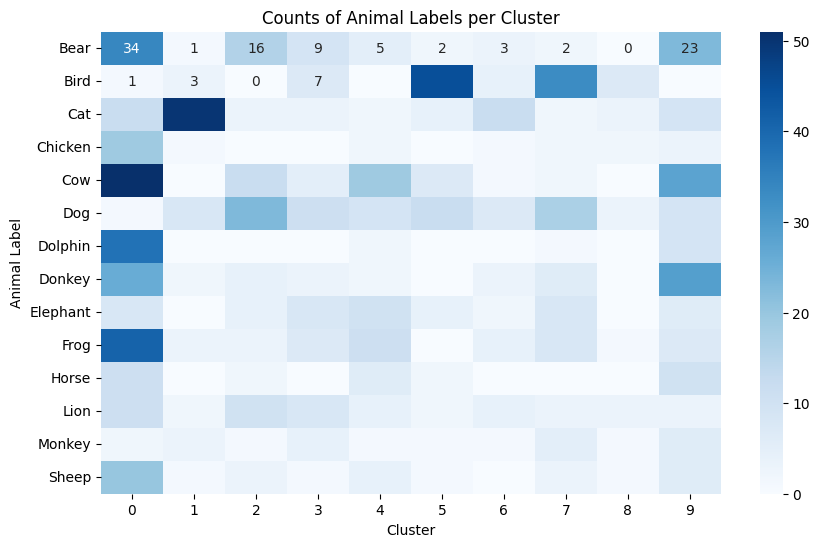

Adjusted Rand Index (ARI): 0.08
Normalized Mutual Information (NMI): 0.19
Homogeneity Score: 0.18
Completeness Score: 0.21
V-Measure Score: 0.19


In [30]:
# Apply K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(principal_components_spectrogram)

# Create a Contingency Matrix
contingency_matrix_k_means = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(kmeans.n_clusters)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_k_means = contingency_matrix_k_means.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_k_means)

plot_and_compute_metrics(pca_df, contingency_matrix_k_means, expected_clusters, expected_labels)

### Perform Spectral clustering on the principal components

/opt/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


cluster        0   1   2   3   4   5   6   7   8   9
animal_label                                        
Bear          18  15  16  19   3   0  12  12   0   0
Bird          24   0   0   1  10  24  24   0  17   0
Cat            6   8   9   7  62   0   8   0   0   0
Chicken        0   3   2   4   4   0   2   5   0  10
Cow           19  31  32  17   0   0   8  14   0   4
Dog           36  18   1   1  14   0  30   0   0   0
Dolphin        0   7  23  12   0   0   1   6   0   1
Donkey         4  14  14  20   3   0  11   7   0   2
Elephant       7  13   2   9   1   0  17   1   0   0
Frog           3  14  11   4   8   0  15   7   0  23
Horse          5  10   1   8   0   0   0   7   0   0
Lion          12   6   1   3   8   0  12   8   0   0
Monkey         2   2   0   5   4   0  10   2   0   0
Sheep          4   7   4   6   2   0   4   5   0   8


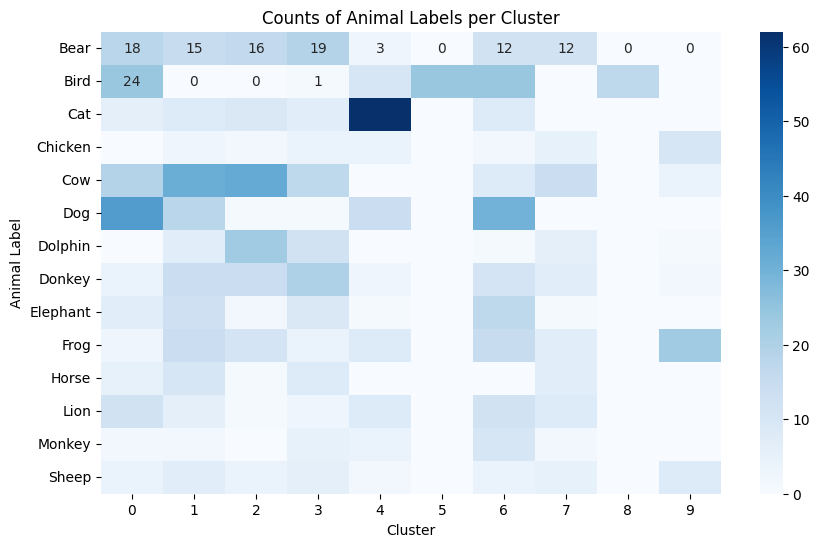

Adjusted Rand Index (ARI): 0.09
Normalized Mutual Information (NMI): 0.21
Homogeneity Score: 0.19
Completeness Score: 0.23
V-Measure Score: 0.21


In [32]:
# Apply Spectral Clustering
spectral_clustering = SpectralClustering(
    n_clusters=10, 
    affinity='nearest_neighbors', 
    random_state=42, 
    assign_labels='kmeans'
)
pca_df['cluster'] = spectral_clustering.fit_predict(principal_components_spectrogram)

# Create a Contingency Matrix
contingency_matrix_spectral = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(10) 
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_spectral = contingency_matrix_spectral.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_spectral)

plot_and_compute_metrics(pca_df, contingency_matrix_spectral, expected_clusters, expected_labels)

### Perform GMM clustering on the principal components

cluster        0   1   2   3   4   5   6   7  8   9
animal_label                                       
Bear          34   1  16   9   5   2   3   2  0  23
Bird           1   3   0   7   0  45   4  33  7   0
Cat           12  50   3   3   2   4  12   2  3   9
Chicken       19   1   0   0   2   0   1   2  2   3
Cow           51   0  12   5  19   7   1   2  0  28
Dog            1   8  23  11   9  12   7  17  3   9
Dolphin       38   0   0   0   2   0   0   1  0   9
Donkey        26   2   4   3   2   0   3   6  0  29
Elephant       8   0   4   8  10   4   2   8  0   6
Frog          41   3   3   7  11   0   4   8  1   7
Horse         11   0   2   0   6   2   0   0  0  10
Lion          11   2  10   8   4   2   4   3  3   3
Monkey         2   3   1   4   1   1   1   5  1   6
Sheep         20   1   3   1   4   1   0   3  1   6


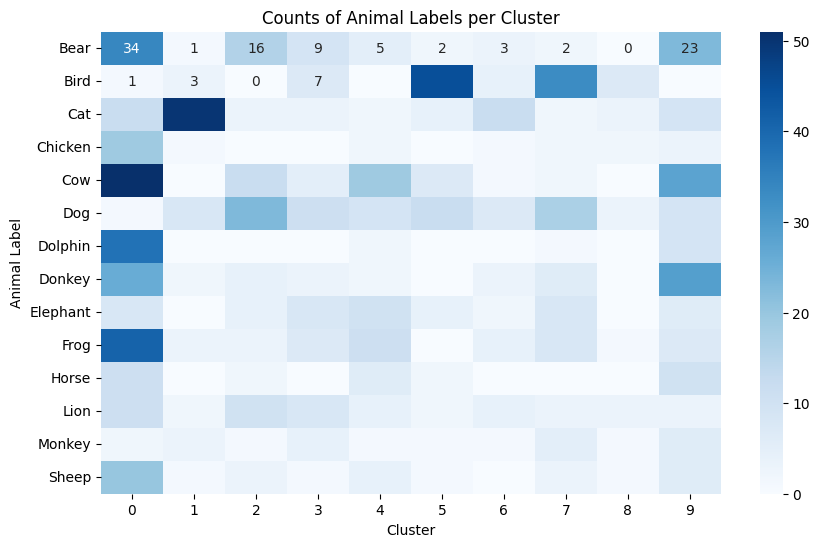

Adjusted Rand Index (ARI): 0.08
Normalized Mutual Information (NMI): 0.19
Homogeneity Score: 0.18
Completeness Score: 0.21
V-Measure Score: 0.19


In [34]:
# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)  
pca_df['cluster'] = gmm.fit_predict(principal_components_spectrogram)

# Create a Contingency Matrix
contingency_matrix_gmm = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(gmm.n_components)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_gmm = contingency_matrix_gmm.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_gmm)

plot_and_compute_metrics(pca_df, contingency_matrix_gmm, expected_clusters, expected_labels)

### Perform Self-Organizing Maps clustering on the principal components

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 6.270372385832755


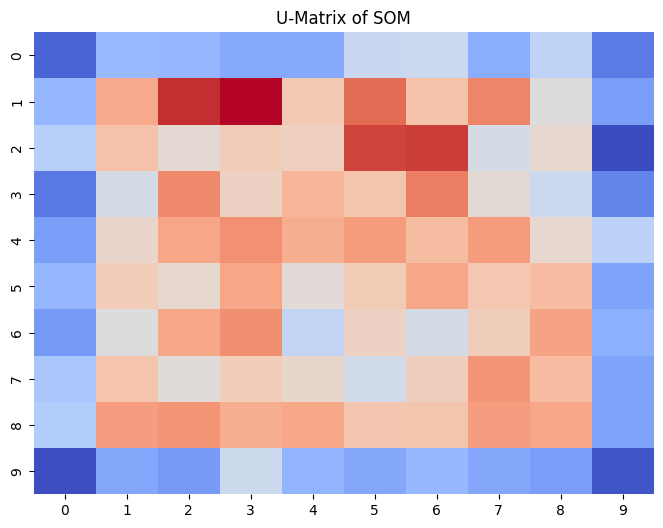

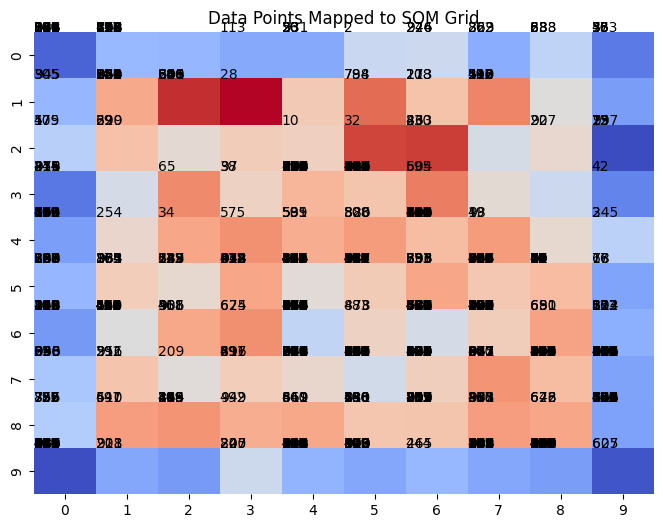

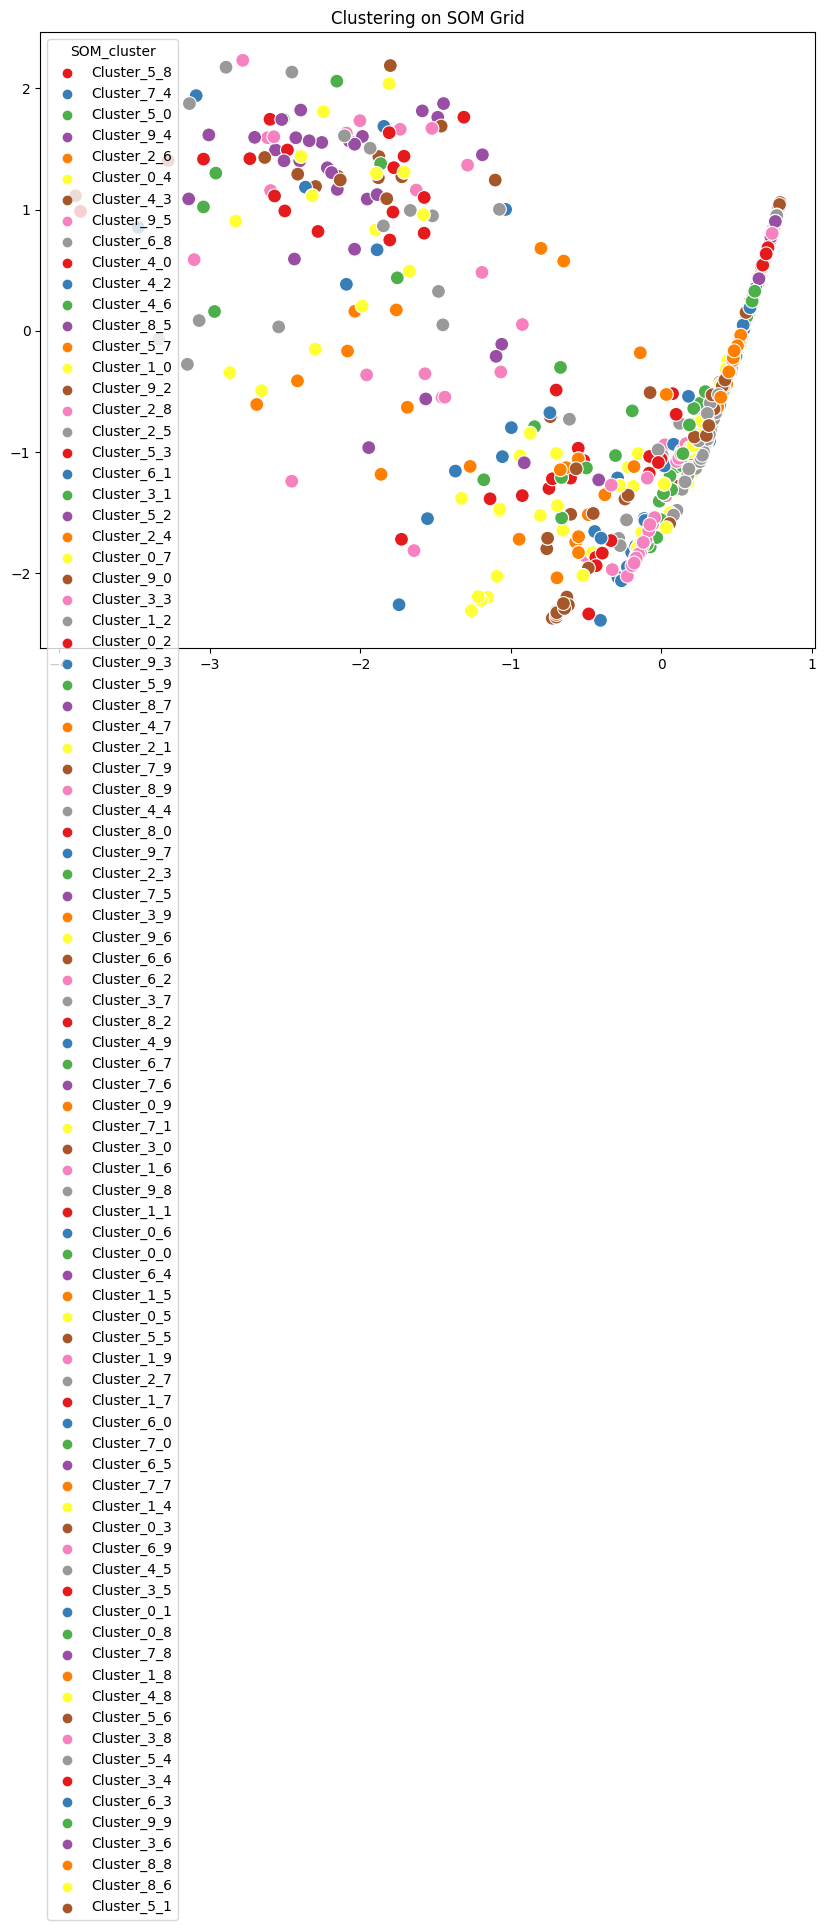

Adjusted Rand Index (ARI): 0.08
Normalized Mutual Information (NMI): 0.32
Homogeneity: 0.41
Completeness: 0.26
V-Measure: 0.32


In [36]:
# Standardize the data 
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(principal_components_spectrogram) 

# Initialize the SOM
som = MiniSom(x=10, y=10, input_len=animal_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)

# Train the SOM
som.train(animal_scaled, 1000, verbose=True)

# Plot the SOM's U-matrix
# U-matrix visualizes the distance between the neurons in the SOM grid. Larger distances mean dissimilarity.
plt.figure(figsize=(8, 6))
plt.title("U-Matrix of SOM")
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)
plt.show()

# Plot the data points on the SOM grid
plt.figure(figsize=(8, 6))
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)

# Assign each data point to a neuron (winning node)
win_map = som.win_map(animal_scaled)

# We can use the same colors to show where the data points map on the SOM grid
for label in range(len(animal_scaled)):
    x, y = som.winner(animal_scaled[label])
    plt.text(x, y, str(label), color='black', fontsize=10)

plt.title('Data Points Mapped to SOM Grid')
plt.show()

# Visualize the SOM clusters
# Cluster the data points by grouping based on their winning node
# You can assign each point a cluster label (i.e., the coordinates of the winning node)
labels_som = np.array([som.winner(x) for x in animal_scaled])

# Convert coordinates to cluster labels
cluster_labels = np.array([f'Cluster_{x[0]}_{x[1]}' for x in labels_som])

pca_df['SOM_cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=animal_scaled[:, 0], y=animal_scaled[:, 1], hue=pca_df['SOM_cluster'], palette='Set1', s=100)
plt.title("Clustering on SOM Grid")
plt.show()

# Clustering performance metrics
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Homogeneity: {homogeneity:.2f}")

completeness = completeness_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Completeness: {completeness:.2f}")

v_measure = v_measure_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"V-Measure: {v_measure:.2f}")

### Results of Spectrogram Feature Extraction Clustering Results

put evaluation metrics for each model here in a table just for easy viewing

# Clustering Results

for each method of feature extraction talk about the results of the clustering algorithms (compare them to each other for the given feature extraction method). also talk about for a given clustering method why it works better or worse for a given feature extraction method. talk about how clustering didn't seem to work too well for either feature extraction method and it didn't seem likely that we'd get good results classifying from the clusters. we pivoted to a cnn feature extractor and various classifiers

# Using cnn as feature extractor and various classifiers (word better)
we used mobile net pretrained (talk about what mobile net is and why we thought this would be good)

For the feature extraction model, we're using the MobileNet convolutional neural network (CNN). This model is an efficient CNN pre-trained on the ImageNet dataset. It's optimized for small datasets like the one we are using in this study. We add in a GlobalAveragePooling2D layer as well as a Dense layer for the feature extraction layers.

#### Loading and preprocessing functions

In [41]:
def preprocess_audio_file(file_path, target_shape=(224, 224)):

    try:
        y, sr = librosa.load(file_path, sr=None)
        
        if y is None or len(y) == 0:
            raise ValueError(f"Audio data is empty for file: {file_path}")
        
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        resized_spec = resize(mel_spec_db, target_shape, mode='constant')
        
        rgb_spec = np.stack([resized_spec] * 3, axis=-1) / 255.0 

        return rgb_spec

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        raise

def process_directory_to_dataframe(parent_directory, target_shape=(224, 224)):

    data, labels = [], []
    for root, _, files in os.walk(parent_directory):
        label = os.path.basename(root)  
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    spectrogram = preprocess_audio_file(file_path, target_shape)
                    if spectrogram is not None:
                        data.append(spectrogram)
                        labels.append(label)
                except Exception as e:
                    print(f"Skipping file {file_path} due to error: {e}")

    print(f"Processed {len(data)} files successfully.")
    return np.array(data), np.array(labels)

parent_directory = "Animal_Sounds"  

print("Processing audio files...")
X, y = process_directory_to_dataframe(parent_directory)

print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Processing audio files...


Note: Illegal Audio-MPEG-Header 0x66616374 at offset 9082.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


Processed 956 files successfully.
Encoding labels...
Splitting data into train and test sets...


## logistic regression classifier

### Implement and Train the logistic regression classifier
discuss what this cell does as a process

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step
Training the Logistic Regression classifier...


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating the Logistic Regression classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.31      0.25        13
           1       1.00      1.00      1.00        21
           2       0.72      0.90      0.80        20
           3       0.33      0.33      0.33         3
           4       0.81      0.91      0.86        23
           5       0.73      0.84      0.78        19
           6       0.82      0.56      0.67        16
           7       0.90      0.82      0.86        11
           8       1.00      0.69      0.82        13
           9       0.86      0.95      0.90        19
          10       0.75      0.75      0.75         8
          11       0.11      0.08      0.10        12
          12       0.50      0.40      0.44         5
          13       1.00      0.44      0.62         9

    accuracy                           0.72       192
   macro avg       0.70      0.64      0.65       192
weighted

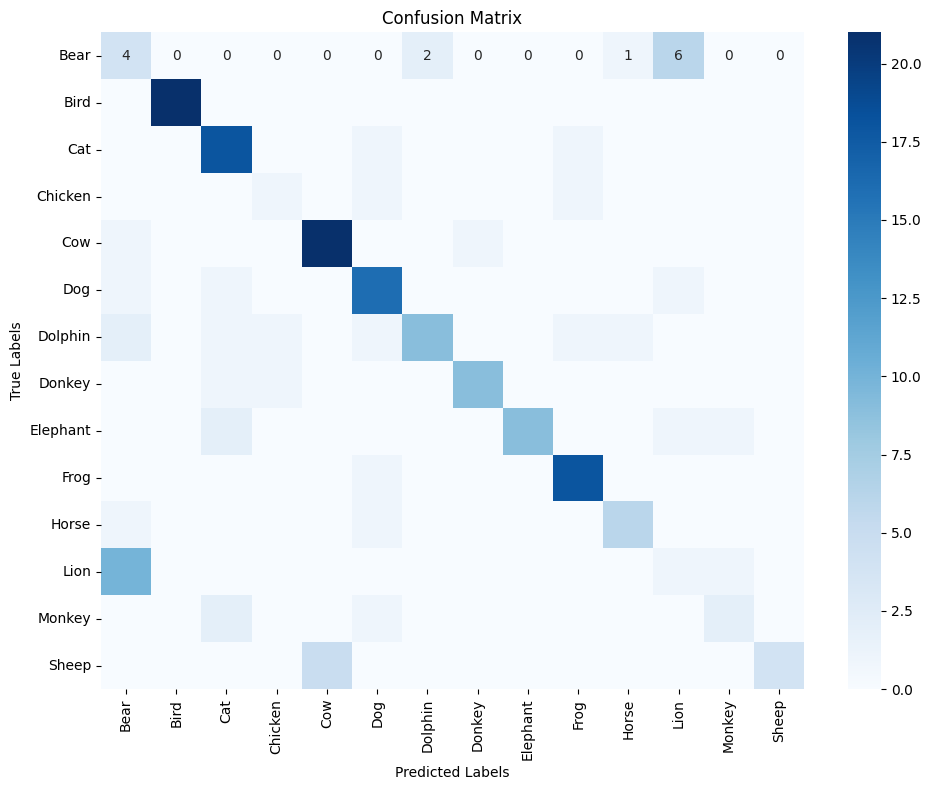

In [44]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Train Logistic Regression Classifier
print("Training the Logistic Regression classifier...")
lr_model = LogisticRegression(
    max_iter=1000,  
    random_state=42,
    multi_class='multinomial',  
    solver='lbfgs'              
)
lr_model.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate the Model
print("Evaluating the Logistic Regression classifier...")
y_pred = lr_model.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Logistic Regression Analysis

talk about how it did and why we think it did well or poorly given our dataset and the strengths and weaknesses of logistic regression

## RNN classifier

### Feature Extraction

talk about what this cell does as a process

In [48]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Reshape features for RNN input
timesteps = 1  
X_train_rnn = X_train_features.reshape(X_train_features.shape[0], timesteps, -1)
X_test_rnn = X_test_features.reshape(X_test_features.shape[0], timesteps, -1)

# Build the RNN model
print("Building the CNN + RNN hybrid model...")

rnn_model = Sequential([
    TimeDistributed(Dense(128, activation='relu'), input_shape=(timesteps, X_train_rnn.shape[2])),
    LSTM(128, return_sequences=False),  # LSTM for temporal modeling
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Classification layer
])

# Compile the model
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
rnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step
Building the CNN + RNN hybrid model...


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 128)         │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,286 (649.55 KB)

 Trainable params: 166,286 (649.55 KB)

 Non-trainable params: 0 (0.00 B)

### Train the RNN classifier

Training the CNN + RNN hybrid model...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1745 - loss: 2.5635 - val_accuracy: 0.3438 - val_loss: 2.2547 - learning_rate: 0.0010
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3960 - loss: 2.0812 - val_accuracy: 0.4792 - val_loss: 1.8010 - learning_rate: 0.0010
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4742 - loss: 1.6946 - val_accuracy: 0.5260 - val_loss: 1.4741 - learning_rate: 0.0010
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5962 - loss: 1.4009 - val_accuracy: 0.5833 - val_loss: 1.2593 - learning_rate: 0.0010
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6741 - loss: 1.1190 - val_accuracy: 0.6146 - val_loss: 1.1297 - learning_rate: 0.0010
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6919 - loss: 1.0028 - val_accuracy: 0.6615 - val_loss: 1.0122 - learning_rate: 0.0010
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

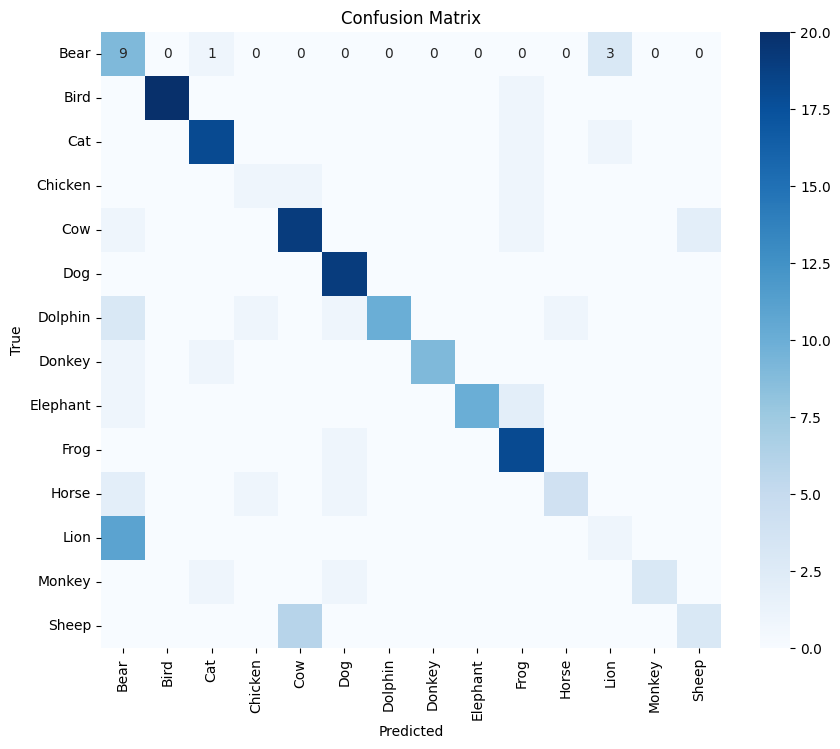

In [50]:
# Train the model
print("Training the CNN + RNN hybrid model...")

# Early Stopping to reduce overfitting by stopping training when validation loss does not change for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning Rate Scheduler to reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce LR by a factor of 0.5
    patience=3,          # Wait 3 epochs before reducing LR
    verbose=1,
    min_lr=1e-6          # Minimum learning rate
)

history = rnn_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_test_rnn, y_test),
    epochs=50,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_probs = rnn_model.predict(X_test_rnn)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true = np.argmax(y_test, axis=1)  # True classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### RNN Analysis

talk about how it did and why we think it did well or poorly given our dataset and the strengths and weaknesses of rnns

## SVM classifier

### Feature Extraction and Training

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
Training the SVM classifier...
Evaluating the SVM classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.54      0.40        13
           1       0.95      1.00      0.98        21
           2       0.68      0.85      0.76        20
           3       0.20      0.33      0.25         3
           4       0.78      0.91      0.84        23
           5       0.77      0.89      0.83        19
           6       0.91      0.62      0.74        16
           7       0.90      0.82      0.86        11
           8       0.80      0.92      0.86        13
           9       0.95      0.95      0.95        19
          10       0.67      0.50      0.57         8
          11       0.00      0.00      0.00        12
          12       1.00      0

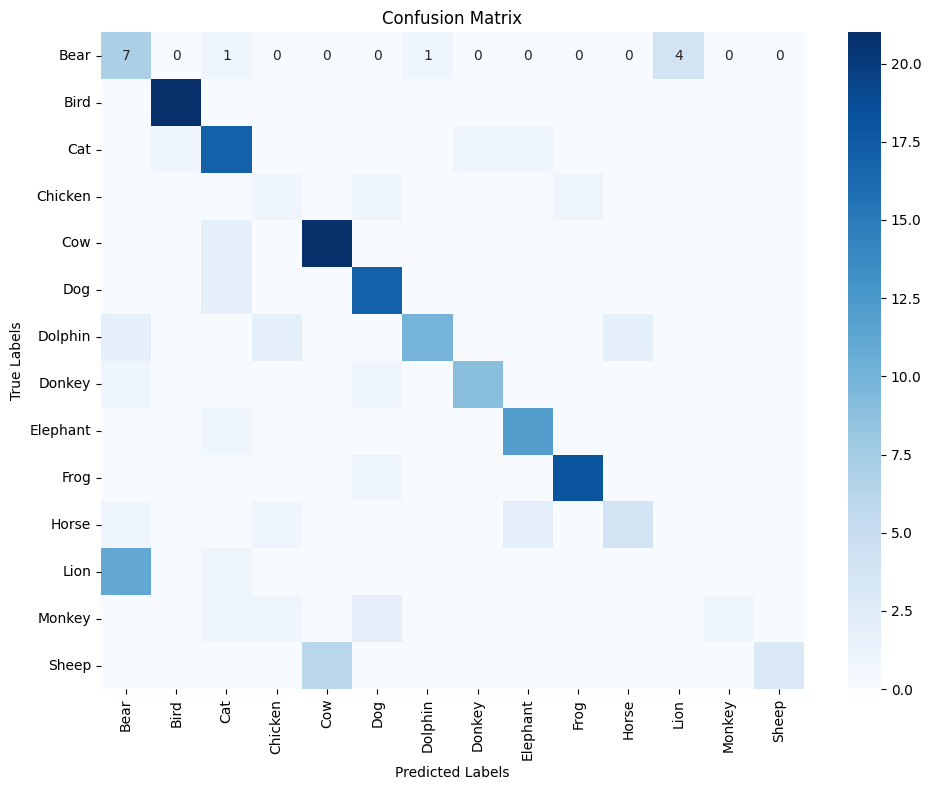

In [54]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Train-Test Split after PCA
print("Training the SVM classifier...")

# Train SVM
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate SVM
print("Evaluating the SVM classifier...")
y_pred = svm_classifier.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### SVM Analysis

talk about how it did and why we think it did well or poorly given our dataset and the strengths and weaknesses of SVMs

## XGBoost classifier

### Feature Extraction and Training

In [ ]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Apply PCA
print("Applying PCA to extracted features...")
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Check the number of components selected
print(f"Number of components selected by PCA: {pca.n_components_}")

# Train XGBoost Classifier
print("Training the XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multiclass classification
    num_class=y_train.shape[1],  # Number of classes
    use_label_encoder=False,     # Suppress warnings
    eval_metric='mlogloss',      # Log loss for multiclass
    random_state=42
)

xgb_model.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate the Model
print("Evaluating the XGBoost classifier...")
y_pred = xgb_model.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
 3/24 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step

### XGBoost Analysis

talk about how it did and why we think it did well or poorly given our dataset and the strengths and weaknesses of XGBoost

## CNN as feature extractor and Various Classifiers results

put it all together in a table for easy viewing. proabably accuracy as the metric

# Discussion

discuss overall what we saw with all the different models and why some did better than others. also talk about the three methods of feature extraction and why we think the cnn feature extractor did the best. talk about how we could improve the models and what we would do differently if we had more time

# Limitations

compute power (could try bigger and more complex models with more compute), time (more time we could try different shit), dataset size (more data = more better)

# Conclusion

wrap everything up high level, basically restating the abstract in different words. talk about future directions with this

# References

just cite some links to a paper about each model (like how it works or whatever) so it can look good cuz we'd have like 8 sources 